Epoch 1/33, Validation Loss: 0.6510
Epoch 2/33, Validation Loss: 0.5612
Epoch 3/33, Validation Loss: 0.5181
Epoch 4/33, Validation Loss: 0.4953
Epoch 5/33, Validation Loss: 0.5022
Epoch 6/33, Validation Loss: 0.5019
Epoch 7/33, Validation Loss: 0.4851
Epoch 8/33, Validation Loss: 0.4814
Epoch 9/33, Validation Loss: 0.4785
Epoch 10/33, Validation Loss: 0.4727
Epoch 11/33, Validation Loss: 0.4772
Epoch 12/33, Validation Loss: 0.4726
Epoch 13/33, Validation Loss: 0.4687
Epoch 14/33, Validation Loss: 0.4748
Epoch 15/33, Validation Loss: 0.4642
Epoch 16/33, Validation Loss: 0.4805
Epoch 17/33, Validation Loss: 0.4692
Epoch 18/33, Validation Loss: 0.4758
Epoch 19/33, Validation Loss: 0.4653
Epoch 20/33, Validation Loss: 0.4653
Epoch 21/33, Validation Loss: 0.4668
Epoch 22/33, Validation Loss: 0.4487
Epoch 23/33, Validation Loss: 0.4736
Epoch 24/33, Validation Loss: 0.4667
Epoch 25/33, Validation Loss: 0.4579
Epoch 26/33, Validation Loss: 0.4470
Epoch 27/33, Validation Loss: 0.4389
Epoch 28/3

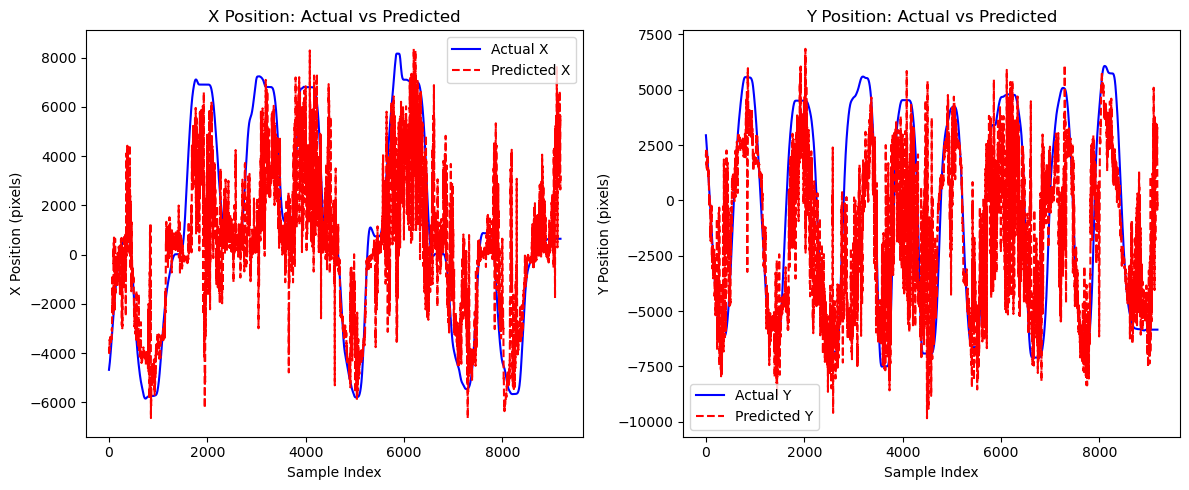

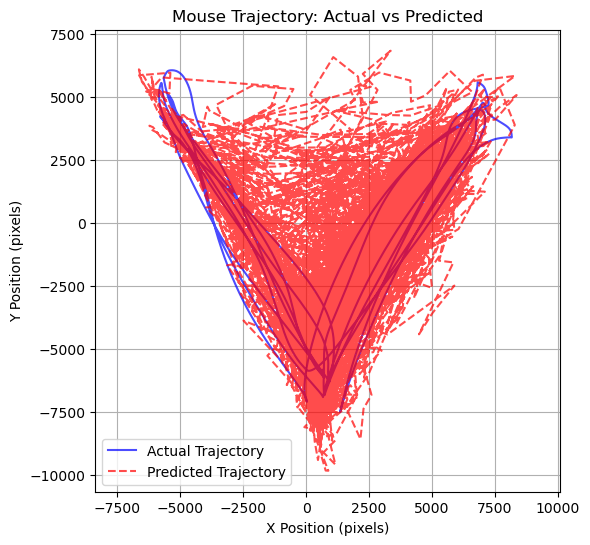

In [1]:
# I have tested and trained 3 AI models
# First one is 3 layer MLP with dropout rate 0.3 and epoch value 33
# Second one is a 3 layer MLP with dropout rate 0.2 and epoch value 10 
# Third one is a Tranformer Encoder 
# 3 Layer MLP with dropout rate 0.3 and epoch value of 33.
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load data from .mat file
mat = scipy.io.loadmat('../data/delta_reach_20080724-111450-001_Processed.mat')
mouse_pos = mat['mouse_position']
time = mat['time_base'].squeeze()
neural_data = mat['neural_data_pro']

# Ensure correct shapes
if mouse_pos.shape[0] == 2 and mouse_pos.shape[1] != 2:
    mouse_pos = mouse_pos.T
if neural_data.shape[0] < neural_data.shape[1]:
    neural_data = neural_data.T

# Align data lengths
min_len = min(len(time), neural_data.shape[0], mouse_pos.shape[0])
time = time[:min_len]
mouse_pos = mouse_pos[:min_len]
neural_data = neural_data[:min_len]

# Split data into training and validation sets (90-10 sequential split)
X = neural_data
y = mouse_pos
split_index = int(0.90 * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_val = X[split_index:]
y_val = y[split_index:]

# Normalize input and output data
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the MLP model with funnel structure
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),  # 256 -> 128
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, hidden_size // 4),  # 128 -> 64
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 4, 2)  # 64 -> 2
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize model, loss, and optimizer
model = MLP(input_size=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 33

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Evaluate on validation set
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_val_tensor).numpy()
    y_true_norm = y_val_tensor.numpy()

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_norm)
y_true = scaler_y.inverse_transform(y_true_norm)

# Compute performance metric
r2 = r2_score(y_true, y_pred)

print("\nPerformance Metric:")
print(f"Validation R² Score: {r2:.4f}")

# Visualize results
# Time series plots for X and Y positions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_true[:, 0], label='Actual X', color='blue')
plt.plot(y_pred[:, 0], label='Predicted X', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('X Position (pixels)')
plt.title('X Position: Actual vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_true[:, 1], label='Actual Y', color='blue')
plt.plot(y_pred[:, 1], label='Predicted Y', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Y Position (pixels)')
plt.title('Y Position: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(6, 6))
plt.plot(y_true[:, 0], y_true[:, 1], label='Actual Trajectory', color='blue', alpha=0.7)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='Predicted Trajectory', color='red', alpha=0.7, linestyle='--')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.title('Mouse Trajectory: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Epoch 1/10, Validation Loss: 0.6741
Epoch 2/10, Validation Loss: 0.5686
Epoch 3/10, Validation Loss: 0.5233
Epoch 4/10, Validation Loss: 0.5151
Epoch 5/10, Validation Loss: 0.5132
Epoch 6/10, Validation Loss: 0.4971
Epoch 7/10, Validation Loss: 0.4869
Epoch 8/10, Validation Loss: 0.4840
Epoch 9/10, Validation Loss: 0.4761
Epoch 10/10, Validation Loss: 0.4676

Performance Metric:
Validation R² Score: 0.4668


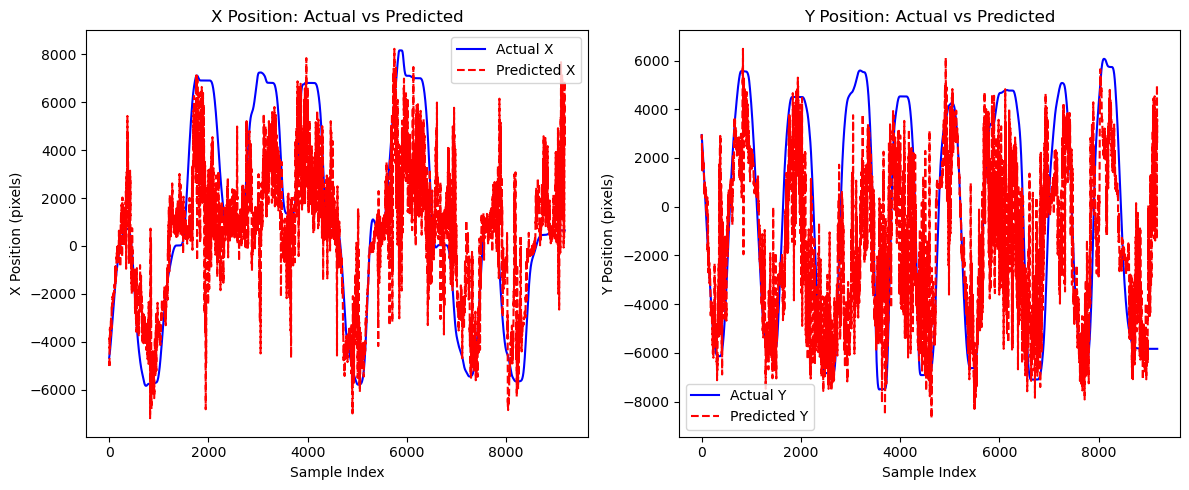

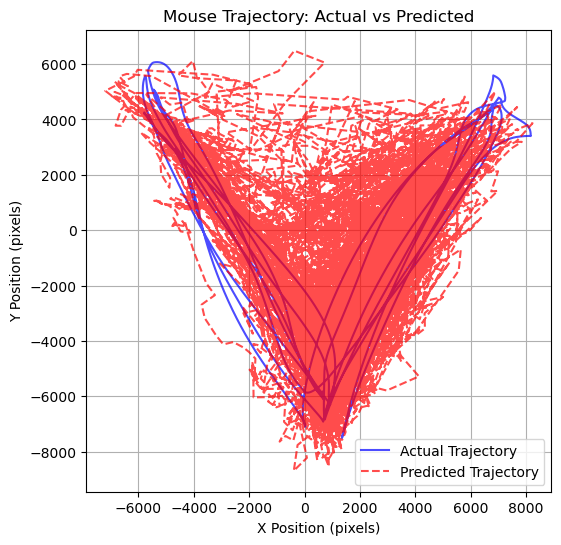

In [2]:
##Changing the dproput rate from 0.3 to 0.2 and checking how our model performs 
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load data from .mat file
mat = scipy.io.loadmat('../data/delta_reach_20080724-111450-001_Processed.mat')
mouse_pos = mat['mouse_position']
time = mat['time_base'].squeeze()
neural_data = mat['neural_data_pro']

# Ensure correct shapes
if mouse_pos.shape[0] == 2 and mouse_pos.shape[1] != 2:
    mouse_pos = mouse_pos.T
if neural_data.shape[0] < neural_data.shape[1]:
    neural_data = neural_data.T

# Align data lengths
min_len = min(len(time), neural_data.shape[0], mouse_pos.shape[0])
time = time[:min_len]
mouse_pos = mouse_pos[:min_len]
neural_data = neural_data[:min_len]

# Split data into training and validation sets (90-10 sequential split)
X = neural_data
y = mouse_pos
split_index = int(0.90 * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_val = X[split_index:]
y_val = y[split_index:]

# Normalize input and output data
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the MLP model with funnel structure
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),  # 256 -> 128
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, hidden_size // 4),  # 128 -> 64
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 4, 2)  # 64 -> 2
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize model, loss, and optimizer
model = MLP(input_size=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Evaluate on validation set
model.eval()
with torch.no_grad():
    y_pred_norm = model(X_val_tensor).numpy()
    y_true_norm = y_val_tensor.numpy()

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_norm)
y_true = scaler_y.inverse_transform(y_true_norm)

# Compute performance metric
r2 = r2_score(y_true, y_pred)

print("\nPerformance Metric:")
print(f"Validation R² Score: {r2:.4f}")

# Visualize results
# Time series plots for X and Y positions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_true[:, 0], label='Actual X', color='blue')
plt.plot(y_pred[:, 0], label='Predicted X', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('X Position (pixels)')
plt.title('X Position: Actual vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_true[:, 1], label='Actual Y', color='blue')
plt.plot(y_pred[:, 1], label='Predicted Y', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Y Position (pixels)')
plt.title('Y Position: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(6, 6))
plt.plot(y_true[:, 0], y_true[:, 1], label='Actual Trajectory', color='blue', alpha=0.7)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='Predicted Trajectory', color='red', alpha=0.7, linestyle='--')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.title('Mouse Trajectory: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Epoch 1/15, Validation Loss: 0.3844
Epoch 2/15, Validation Loss: 0.4531
Epoch 3/15, Validation Loss: 0.6085
Epoch 4/15, Validation Loss: 0.4405
Epoch 5/15, Validation Loss: 0.5130
Epoch 6/15, Validation Loss: 0.4323
Epoch 7/15, Validation Loss: 0.4991
Epoch 8/15, Validation Loss: 0.6262
Epoch 9/15, Validation Loss: 0.5125
Epoch 10/15, Validation Loss: 0.7298
Epoch 11/15, Validation Loss: 0.6065
Epoch 12/15, Validation Loss: 0.4883
Epoch 13/15, Validation Loss: 0.5094
Epoch 14/15, Validation Loss: 0.4620
Epoch 15/15, Validation Loss: 0.4189

Performance Metric:
Validation R² Score: 0.5203


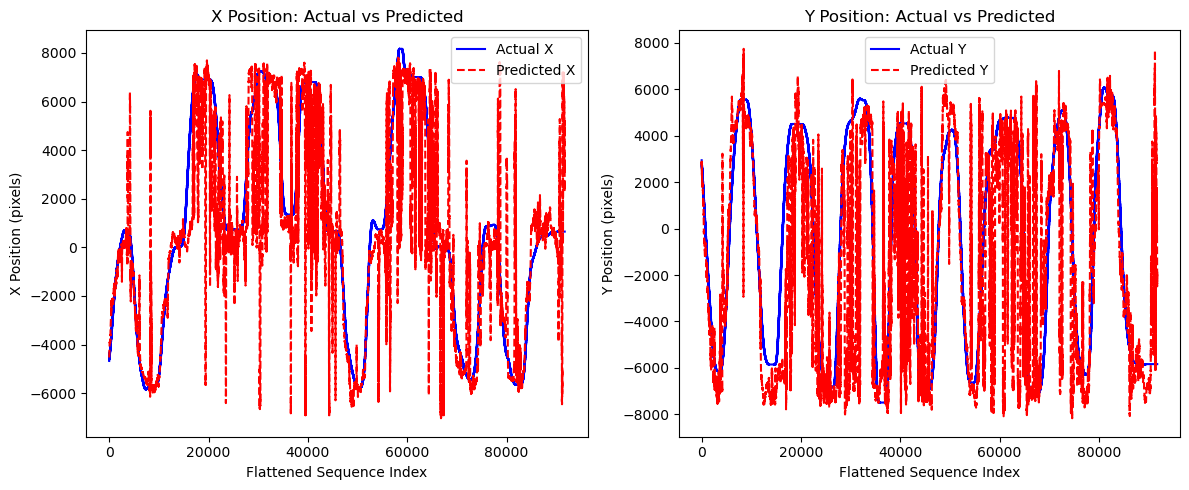

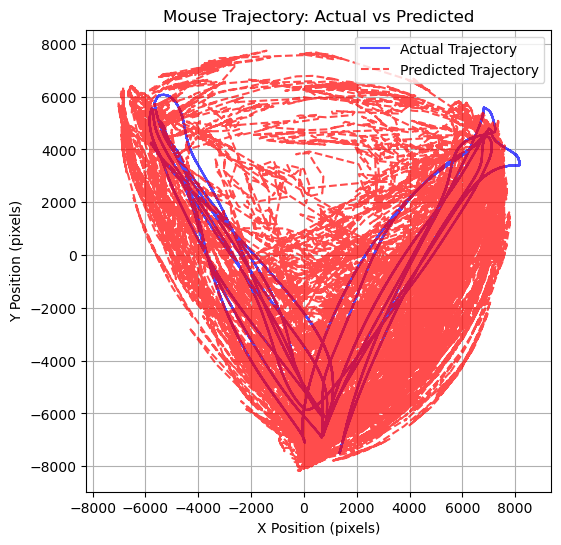

In [2]:
#This is an Trasnformer Encoder which performes basically worse compared to MLP. 
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load data from .mat file
mat = scipy.io.loadmat('../data/delta_reach_20080724-111450-001_Processed.mat')
mouse_pos = mat['mouse_position']
time = mat['time_base'].squeeze()
neural_data = mat['neural_data_pro']

# Ensure correct shapes
if mouse_pos.shape[0] == 2 and mouse_pos.shape[1] != 2:
    mouse_pos = mouse_pos.T
if neural_data.shape[0] < neural_data.shape[1]:
    neural_data = neural_data.T

# Align data lengths
min_len = min(len(time), neural_data.shape[0], mouse_pos.shape[0])
time = time[:min_len]
mouse_pos = mouse_pos[:min_len]
neural_data = neural_data[:min_len]

# Split data into training and validation sets (90-10 sequential split)
X = neural_data
y = mouse_pos
split_index = int(0.90 * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_val = X[split_index:]
y_val = y[split_index:]

# Normalize input and output data
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)

# Define sequence length
seq_len = 10

# Function to create sequences
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i+seq_len]
        sequences.append(seq)
    return np.array(sequences)

# Create sequences for training and validation
X_train_seq = create_sequences(X_train_norm, seq_len)
y_train_seq = create_sequences(y_train_norm, seq_len)
X_val_seq = create_sequences(X_val_norm, seq_len)
y_val_seq = create_sequences(y_val_norm, seq_len)

# Convert to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_seq_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq_tensor = torch.tensor(y_val_seq, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
val_dataset = TensorDataset(X_val_seq_tensor, y_val_seq_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=4, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        out = self.fc(x)
        return out

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]  # number of features in neural_data
hidden_size = 128
num_layers = 2
output_size = 2  # x and y coordinates
num_heads = 4

model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Evaluate on validation set
model.eval()
y_pred_all = []
y_true_all = []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x)
        y_pred_all.append(outputs.view(-1, 2))
        y_true_all.append(batch_y.view(-1, 2))
y_pred_norm = torch.cat(y_pred_all, dim=0).numpy()
y_true_norm = torch.cat(y_true_all, dim=0).numpy()

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_norm)
y_true = scaler_y.inverse_transform(y_true_norm)

# Compute performance metric
r2 = r2_score(y_true, y_pred)

print("\nPerformance Metric:")
print(f"Validation R² Score: {r2:.4f}")

# Visualize results
# Time series plots for X and Y positions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_true[:, 0], label='Actual X', color='blue')
plt.plot(y_pred[:, 0], label='Predicted X', color='red', linestyle='--')
plt.xlabel('Flattened Sequence Index')
plt.ylabel('X Position (pixels)')
plt.title('X Position: Actual vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_true[:, 1], label='Actual Y', color='blue')
plt.plot(y_pred[:, 1], label='Predicted Y', color='red', linestyle='--')
plt.xlabel('Flattened Sequence Index')
plt.ylabel('Y Position (pixels)')
plt.title('Y Position: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Trajectory plot
plt.figure(figsize=(6, 6))
plt.plot(y_true[:, 0], y_true[:, 1], label='Actual Trajectory', color='blue', alpha=0.7)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='Predicted Trajectory', color='red', alpha=0.7, linestyle='--')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.title('Mouse Trajectory: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()